# Original notebook:
https://www.kaggle.com/code/takanashihumbert/cibmtr-using-official-metric-in-tree-based-models/notebook

In [2]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, Back, Style

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder
import os, glob, math, gc, warnings, random, joblib
from sklearn.metrics import roc_auc_score

from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb
print("we are using xgboost ==", xgb.__version__)
from lightgbm import LGBMRegressor, callback

from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

we are using xgboost == 2.1.3


In [27]:
class ParticipantVisibleError(Exception):
    pass


def custom_score(solution, submission, row_id_column_name, prediction_label='prediction', print_info=True):
    
    del solution[row_id_column_name]
    del submission[row_id_column_name]
    
    event_label = 'efs'
    interval_label = 'efs_time'
    
    for col in submission.columns:
        if not pd.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f'Submission column {col} must be a number')
    # Merging solution and submission dfs on ID
    merged_df = pd.concat([solution, submission], axis=1)
    merged_df.reset_index(inplace=True)
    merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)
    metric_dict = {}
    for race in sorted(merged_df_race_dict.keys()):
        # Retrieving values from y_test based on index
        indices = sorted(merged_df_race_dict[race])
        merged_df_race = merged_df.iloc[indices]
        # Calculate the concordance index
        c_index_race = concordance_index(
                        merged_df_race[interval_label],
                        -merged_df_race[prediction_label],
                        merged_df_race[event_label])

        metric_dict[race] = c_index_race

    race_c_index = list(metric_dict.values())
    c_score = float(np.mean(race_c_index) - np.std(race_c_index))
    if print_info:
        print(f"{Fore.GREEN}{Style.BRIGHT}# c-index={c_score:.4f}, mean={np.mean(race_c_index):.4f} std={np.std(race_c_index):.4f}{Style.RESET_ALL}")
    
    return c_score, metric_dict


def display_overall(df):
    
    race_groups = [
        'American Indian or Alaska Native', 'Asian',
       'Black or African-American', 'More than one race',
       'Native Hawaiian or other Pacific Islander', 'White'
    ]
    df['mean'] = df[race_groups].mean(axis=1)
    df['std'] = np.std(df[race_groups], axis=1)
    df['score'] = df['mean'] - df['std']
    df = df.T
    df['Overall'] = df.mean(axis=1)
    temp = df.drop(index=['std']).values
    display(df
            .iloc[:len(race_groups)]
            .style
            .format(precision=4)
            .background_gradient(axis=None, vmin=temp.min(), vmax=temp.max(), cmap="cool")
            .concat(df.iloc[len(race_groups):].style.format(precision=3))
           )


# Load Train and Test

In [28]:
test = pd.read_csv("../preprocessed_data/custom_test_0.1_imbalanced.csv")
print("Test shape:", test.shape )

test_balanced = pd.read_csv("../preprocessed_data/custom_test_0.1_balanced.csv")
print("Balanced Test shape:", test_balanced.shape )

train = pd.read_csv("../preprocessed_data/custom_train_0.9_balanced.csv")
print("Train shape:",train.shape)

Test shape: (1057, 60)
Balanced Test shape: (2880, 60)
Train shape: (25920, 60)


In [29]:
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    """
    Transform using survival probability estimates
    """
    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], df[event_col])
    y = kmf.survival_function_at_times(df[time_col]).values
    
    return y

# Let's substract 0.1 instead of 0.2 from the Kaplan Meier survival scores 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


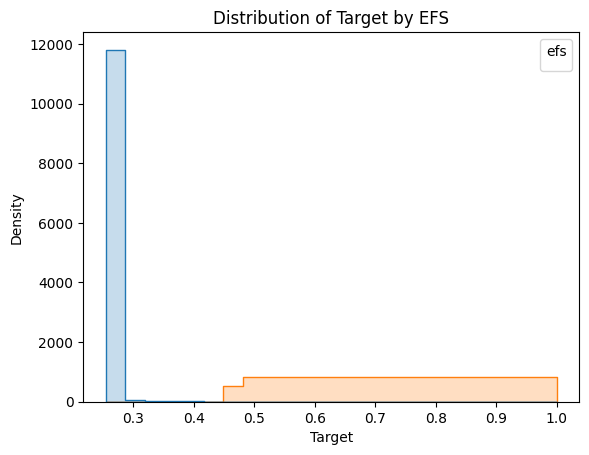

In [30]:
SUBTRACT_KP_SCORE = 0.1

train["label"] = transform_survival_probability(train, time_col='efs_time', event_col='efs')
train.loc[train['efs']==0, 'label'] -= SUBTRACT_KP_SCORE # or -0.1 according to other notebook

test['label'] = transform_survival_probability(test, time_col='efs_time', event_col='efs')
test.loc[test['efs']==0, 'label'] -= SUBTRACT_KP_SCORE # or -0.1 according to other notebook
test_balanced['label'] = transform_survival_probability(test_balanced, time_col='efs_time', event_col='efs')
test_balanced.loc[test_balanced['efs']==0, 'label'] -= SUBTRACT_KP_SCORE # or -0.1 according to other notebook

sns.histplot(data=train, x='label', hue='efs', element='step', common_norm=False)
plt.legend(title='efs')
plt.title('Distribution of Target by EFS')
plt.xlabel('Target')
plt.ylabel('Density')
plt.show()

# Let's convert year_hct to year_hct_from_baseline to avoid a big difference in scale

In [31]:
MIN_YEAR = train['year_hct'].min() # 2008
train['year_hct_relative'] = train['year_hct'] - MIN_YEAR
train.drop(columns=['year_hct'], inplace=True)

test['year_hct_relative'] = test['year_hct'] - MIN_YEAR
test.drop(columns=['year_hct'], inplace=True)   

test_balanced['year_hct_relative'] = test_balanced['year_hct'] - MIN_YEAR   
test_balanced.drop(columns=['year_hct'], inplace=True)  


In [32]:
RMV = ["ID","efs","efs_time","label",'y','kfold']
FEATURES = [c for c in train.columns if not c in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

There are 57 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10', 'year_hct_relative']


In [33]:
CAT_FEATURES = []
for c in FEATURES:
    if train[c].dtype=="object":
        CAT_FEATURES.append(c)
        train[c] = train[c].fillna("NAN")
        test[c] = test[c].fillna("NAN")
        test_balanced[c] = test_balanced[c].fillna("NAN")

In [34]:
combined = pd.concat([train, test, test_balanced], axis=0, ignore_index=True)

print("The CATEGORICAL FEATURES: ", end="")
for c in FEATURES:
    if c in CAT_FEATURES:
        print(f"{c}, ", end="")
        combined[c] = combined[c].astype("category")
    else:
        if combined[c].dtype == "float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype == "int64":
            combined[c] = combined[c].astype("int32")

train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):len(train) + len(test)].reset_index(drop=True).copy()
test_balanced = combined.iloc[len(train) + len(test):].reset_index(drop=True).copy()


The CATEGORICAL FEATURES: dri_score, psych_disturb, cyto_score, diabetes, tbi_status, arrhythmia, graft_type, vent_hist, renal_issue, pulm_severe, prim_disease_hct, cmv_status, tce_imm_match, rituximab, prod_type, cyto_score_detail, conditioning_intensity, ethnicity, obesity, mrd_hct, in_vivo_tcd, tce_match, hepatic_severe, prior_tumor, peptic_ulcer, gvhd_proph, rheum_issue, sex_match, race_group, hepatic_mild, tce_div_match, donor_related, melphalan_dose, cardiac, pulm_moderate, 

In [35]:
test.columns
# test_balanced.columns

Index(['ID', 'dri_score', 'psych_disturb', 'cyto_score', 'diabetes',
       'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia',
       'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue',
       'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status',
       'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6',
       'hla_match_c_low', 'rituximab', 'hla_match_drb1_low',
       'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail',
       'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct',
       'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe',
       'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer',
       'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue',
       'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score',
       'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related',
       'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high',
       

In [36]:
folds = 5
train['kfold'] = -1  

skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
groups = train['efs'].astype(str)
for fold, (train_idx, val_idx) in enumerate(skf.split(X=train, y=groups)):
    train.loc[val_idx, 'kfold'] = fold

# Custom Metrics

In [37]:
def CIndexMetric_XGB(y_true, y_pred):
    ds_pred["prediction"] = y_pred
    cindex_score, _ = custom_score(ds_true.copy(), ds_pred.copy(), "ID", print_info=False)
    return -cindex_score

def CIndexMetric_LGB(y_true, y_pred):
    ds_pred["prediction"] = y_pred
    cindex_score, _ = custom_score(ds_true.copy(), ds_pred.copy(), "ID", print_info=False)
    return ('C-Index', cindex_score, True)

# XGBoost

In [38]:
%%time

oof_xgb = train[['kfold','ID','efs','efs_time','label','race_group']].copy()
oof_xgb['prediction'] = 0.0
feature_importances_xgb = pd.DataFrame()
feature_importances_xgb['feature'] = FEATURES
metric_df = []

for fold in range(skf.n_splits):
    
    x_train = train[train.kfold != fold].copy()
    x_valid = train[train.kfold == fold].copy()

    y_train = x_train['label']
    y_valid = x_valid['label']
    y_label = x_valid['efs']

    x_train = x_train[FEATURES]
    x_valid = x_valid[FEATURES]

    # define two extra dataframe for the custom metric
    ds_true = oof_xgb.loc[oof_xgb.kfold==fold, ["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
    ds_pred = oof_xgb.loc[oof_xgb.kfold==fold, ["ID"]].copy().reset_index(drop=True)
    
    clf = XGBRegressor(
        tree_method="hist",
        max_depth=3,
        colsample_bytree=0.5, 
        subsample=0.8, 
        n_estimators=10000,  
        learning_rate=0.03,
        early_stopping_rounds=100,
        objective='reg:squarederror',
        enable_categorical=True,
        min_child_weight=5,
        eval_metric=CIndexMetric_XGB, # the custom metric
        disable_default_eval_metric=True # only show the custom metric
    )
    clf.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        verbose=500,
    )
    feature_importances_xgb[f'fold_{fold + 1}'] = feature_importances_xgb['feature'].map(clf.get_booster().get_score())

    preds_valid = clf.predict(x_valid)
    oof_xgb.loc[oof_xgb.kfold==fold, 'prediction'] = preds_valid

    # don't use joblib or pickle to save the model(Cannot load it)
    clf.save_model(f"xgb/xgb_model_simple_preprocessing_{fold}.bin")

    y_true = oof_xgb.loc[oof_xgb.kfold==fold, ["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
    y_pred = oof_xgb.loc[oof_xgb.kfold==fold, ["ID","prediction"]].copy().reset_index(drop=True)
    m, metric_dict = custom_score(y_true, y_pred, "ID", print_info=True)
    metric_df.append(metric_dict)

[0]	validation_0-CIndexMetric_XGB:-0.59069
[500]	validation_0-CIndexMetric_XGB:-0.66696
[1000]	validation_0-CIndexMetric_XGB:-0.67368
[1460]	validation_0-CIndexMetric_XGB:-0.67523
# c-index=0.6753, mean=0.6885 std=0.0132
[0]	validation_0-CIndexMetric_XGB:-0.59093
[500]	validation_0-CIndexMetric_XGB:-0.66704
[1000]	validation_0-CIndexMetric_XGB:-0.67246
[1491]	validation_0-CIndexMetric_XGB:-0.67423
# c-index=0.6746, mean=0.6908 std=0.0162
[0]	validation_0-CIndexMetric_XGB:-0.60004
[500]	validation_0-CIndexMetric_XGB:-0.67429
[1000]	validation_0-CIndexMetric_XGB:-0.67706
[1134]	validation_0-CIndexMetric_XGB:-0.67711
# c-index=0.6772, mean=0.6849 std=0.0077
[0]	validation_0-CIndexMetric_XGB:-0.59214
[500]	validation_0-CIndexMetric_XGB:-0.66396
[1000]	validation_0-CIndexMetric_XGB:-0.66900
[1354]	validation_0-CIndexMetric_XGB:-0.66975
# c-index=0.6699, mean=0.6824 std=0.0124
[0]	validation_0-CIndexMetric_XGB:-0.59675
[500]	validation_0-CIndexMetric_XGB:-0.67131
[1000]	validation_0-CIndexMe

In [46]:

def evaluate_test_set(test_set, model_prefix, skf, FEATURES, custom_score, dataset_name="test set"):
    """
    Evaluate the model on a given test set (imbalanced or balanced).
    
    Parameters:
        test_set (pd.DataFrame): The test set to evaluate.
        model_prefix (str): Prefix for the saved model filenames.
        skf (StratifiedKFold): Cross-validation object to determine the number of folds.
        FEATURES (list): List of feature columns.
        custom_score (function): Function to compute custom evaluation metric.
        dataset_name (str): Name of the dataset for logging purposes.
    
    Returns:
        None (prints evaluation results)
    """
    print(f"Evaluating on {dataset_name}...")

    # Ensure the test set has the required feature columns
    if not set(FEATURES).issubset(test_set.columns):
        raise ValueError(f"{dataset_name} does not have all required feature columns.")

    # Initialize an array to accumulate predictions from each fold
    test_predictions = np.zeros(len(test_set))

    # Initialize a dictionary to store the evaluation metric for each fold
    metric_df = []

    # Loop over folds, load each saved model, and predict on the test set
    for fold in range(skf.n_splits):
        model_filename = f"xgb/{model_prefix}_simple_preprocessing_{fold}.bin"
        clf = XGBRegressor()  # We only use this to load the saved booster
        clf.load_model(model_filename)
        fold_pred = clf.predict(test_set[FEATURES])
        test_set[f'prediction_{fold}'] = fold_pred

        # If labels exist, compute the custom metric for this fold
        if "label" in test_set.columns:
            y_true_test = test_set[["ID", "efs", "efs_time", "race_group"]].copy().reset_index(drop=True)
            y_pred_test = test_set[["ID", f"prediction_{fold}"]].copy().reset_index(drop=True)
            m, metric_dict = custom_score(y_true_test, y_pred_test, "ID", print_info=True, prediction_label=f"prediction_{fold}")
            print(f"{dataset_name} evaluation metric for fold {fold}:", metric_dict)
            metric_df.append(metric_dict)

        test_predictions += fold_pred

    # Average the predictions across folds
    test_predictions /= skf.n_splits
    test_set['ensemble_prediction'] = test_predictions

    print('\nENSEMBLE:')
    # If labels exist, compute the custom metric for an ensemble
    if "label" in test_set.columns:
        y_true_test = test_set[["ID", "efs", "efs_time", "race_group"]].copy().reset_index(drop=True)
        y_pred_test = test_set[["ID", "ensemble_prediction"]].copy().reset_index(drop=True)
        m, ensemble_metric_dict = custom_score(y_true_test, y_pred_test, "ID", print_info=True, prediction_label="ensemble_prediction")
        print(f"{dataset_name} evaluation metric:", metric_dict)
    else:
        print(f"{dataset_name} predictions computed. No labels available for evaluation.")
    return ensemble_metric_dict, metric_df


# Evaluation on full test set

In [40]:
ensemble_balanced_metric_dict, balanced_metric_dicts = evaluate_test_set(test_balanced, "xgb_model", skf, FEATURES, custom_score, dataset_name="balanced test set")


Evaluating on balanced test set...
# c-index=0.6563, mean=0.6685 std=0.0122
balanced test set evaluation metric for fold 0: {'American Indian or Alaska Native': 0.6861515303562469, 'Asian': 0.6768592899714952, 'Black or African-American': 0.6565716843204535, 'More than one race': 0.6623756514875391, 'Native Hawaiian or other Pacific Islander': 0.6522630191242674, 'White': 0.676683591136301}
# c-index=0.6543, mean=0.6695 std=0.0152
balanced test set evaluation metric for fold 1: {'American Indian or Alaska Native': 0.69264014961456, 'Asian': 0.6765212884617551, 'Black or African-American': 0.6512542358432258, 'More than one race': 0.6656606576977098, 'Native Hawaiian or other Pacific Islander': 0.650938942811417, 'White': 0.6797732908253631}
# c-index=0.6575, mean=0.6692 std=0.0117
balanced test set evaluation metric for fold 2: {'American Indian or Alaska Native': 0.6863567942343657, 'Asian': 0.6724878037788569, 'Black or African-American': 0.6531190724835362, 'More than one race': 0.6

In [41]:
display_overall(pd.DataFrame(balanced_metric_dicts))

,0,1,2,3,4,Overall
American Indian or Alaska Native,0.6862,0.6926,0.6864,0.6909,0.6925,0.6897
Asian,0.6769,0.6765,0.6725,0.6728,0.6768,0.6751
Black or African-American,0.6566,0.6513,0.6531,0.6539,0.6579,0.6546
More than one race,0.6624,0.6657,0.6662,0.6640,0.6703,0.6657
Native Hawaiian or other Pacific Islander,0.6523,0.6509,0.6572,0.6534,0.6509,0.6529
White,0.6767,0.6798,0.6795,0.6750,0.6747,0.6771
mean,0.668,0.669,0.669,0.668,0.671,0.669
std,0.012,0.015,0.012,0.013,0.013,0.013
score,0.656,0.654,0.657,0.655,0.657,0.656


In [42]:
test_balanced['race_group'].value_counts(normalize=True)

race_group
More than one race                           0.168056
Asian                                        0.167708
White                                        0.167708
Black or African-American                    0.166667
American Indian or Alaska Native             0.166319
Native Hawaiian or other Pacific Islander    0.163542
Name: proportion, dtype: float64

# Evaluation on imbalanced test subset

In [43]:
ensemble_imbalanced_metric_dict, imbalanced_metric_dicts = evaluate_test_set(test, "xgb_model", skf, FEATURES, custom_score, dataset_name="imbalanced test set")


Evaluating on imbalanced test set...
# c-index=0.5685, mean=0.6329 std=0.0644
imbalanced test set evaluation metric for fold 0: {'American Indian or Alaska Native': 0.6758130081300813, 'Asian': 0.667502850627138, 'Black or African-American': 0.6366289810093845, 'More than one race': 0.4925255704169945, 'Native Hawaiian or other Pacific Islander': 0.6482861400894188, 'White': 0.676683591136301}
# c-index=0.5806, mean=0.6381 std=0.0575
imbalanced test set evaluation metric for fold 1: {'American Indian or Alaska Native': 0.6869918699186992, 'Asian': 0.6565564424173318, 'Black or African-American': 0.6305697184659721, 'More than one race': 0.5161290322580645, 'Native Hawaiian or other Pacific Islander': 0.6587183308494784, 'White': 0.6797732908253631}
# c-index=0.5778, mean=0.6387 std=0.0610
imbalanced test set evaluation metric for fold 2: {'American Indian or Alaska Native': 0.6815718157181572, 'Asian': 0.6586088939566704, 'Black or African-American': 0.6406192270745585, 'More than one 

In [44]:
display_overall(pd.DataFrame(imbalanced_metric_dicts))

,0,1,2,3,4,Overall
American Indian or Alaska Native,0.6758,0.6870,0.6816,0.6883,0.6836,0.6833
Asian,0.6675,0.6566,0.6586,0.6568,0.6591,0.6597
Black or African-American,0.6366,0.6306,0.6406,0.6379,0.6348,0.6361
More than one race,0.4925,0.5161,0.5059,0.4972,0.5138,0.5051
Native Hawaiian or other Pacific Islander,0.6483,0.6587,0.6662,0.6647,0.6580,0.6592
White,0.6767,0.6798,0.6795,0.6750,0.6747,0.6771
mean,0.633,0.638,0.639,0.637,0.637,0.637
std,0.064,0.057,0.061,0.064,0.057,0.061
score,0.568,0.581,0.578,0.572,0.580,0.576


In [45]:
test['race_group'].value_counts(normalize=True)

race_group
White                                        0.456954
Black or African-American                    0.245033
Asian                                        0.108798
American Indian or Alaska Native             0.081362
More than one race                           0.053926
Native Hawaiian or other Pacific Islander    0.053926
Name: proportion, dtype: float64

In [ ]:
# For inference:
# model_path = f"./xxx/xgb_model.bin"
# model = XGBRegressor()
# model.load_model(model_path)
# prediction = model.predict()

# Lightgbm

In [ ]:
%%time
    
oof_lgb = train[['kfold','ID','efs','efs_time','label','race_group']].copy()
oof_lgb['prediction'] = 0.0
feature_importances_lgb = pd.DataFrame()
feature_importances_lgb['feature'] = FEATURES
metric_df = []

for fold in range(skf.n_splits):
    
    x_train = train[train.kfold != fold].copy()
    x_valid = train[train.kfold == fold].copy()

    y_train = x_train['label']
    y_valid = x_valid['label']
    y_label = x_valid['efs']

    x_train = x_train[FEATURES]
    x_valid = x_valid[FEATURES]

    ds_true = oof_lgb.loc[oof_lgb.kfold==fold, ["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
    ds_pred = oof_lgb.loc[oof_lgb.kfold==fold, ["ID"]].copy().reset_index(drop=True)

    lgb_params = {
        'max_depth': 6,
        'num_leaves': 40,
        'learning_rate': 0.03,
        'n_estimators': 10000,
        'objective': 'l2',
        'subsample': 0.8,
        'colsample_bytree': 0.5,
        'n_jobs': -1,
        'verbose': -1,
        'device': 'gpu',
        'metric': 'None' # only show the custom metric
    }
    clf = LGBMRegressor(**lgb_params)
    clf.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        categorical_feature=CAT_FEATURES,
        eval_metric=CIndexMetric_LGB, # the custom metric
        callbacks=[callback.log_evaluation(500), callback.early_stopping(100)]
    )
    feature_importances_lgb[f'fold_{fold + 1}'] = clf.feature_importances_

    preds_valid = clf.predict(x_valid)
    oof_lgb.loc[oof_lgb.kfold==fold, 'prediction'] = preds_valid

    joblib.dump(clf, f"lgb_model_{fold}.pkl")

    y_true = oof_lgb.loc[oof_lgb.kfold==fold, ["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
    y_pred = oof_lgb.loc[oof_lgb.kfold==fold, ["ID","prediction"]].copy().reset_index(drop=True)
    m, metric_dict = custom_score(y_true, y_pred, "ID", print_info=True)
    metric_df.append(metric_dict)

In [ ]:
# For inference:
# model_path = f"./xxx/lgb_model.pkl"
# model = joblib.load(model_path)
# prediction = model.predict()

In [ ]:
y_true = oof_lgb[["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
y_pred = oof_lgb[["ID","prediction"]].copy().reset_index(drop=True)
m, _ = custom_score(y_true, y_pred, "ID", print_info=True)
print(f"Overall official SCORE: {m:.5f}")

metric_df_ = pd.DataFrame(metric_df)
display_overall(metric_df_)

In [ ]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = 0.5*oof_xgb['prediction'].rank(pct=True) + 0.5*oof_lgb['prediction'].rank(pct=True)

m, _ = custom_score(y_true, y_pred, "ID", print_info=True)
print(f"Overall official SCORE: {m:.5f}")